# **COVID-19 Outcome Prediction**
This notebook serves as the main notebook for the Covid-19 Outcome Prediction project. We will be training and assessing different models, and based on the results we will choose the best model to predict the outcome of Covid-19 patients. The models we will be training are:

- K-Nearest Neighbors
- Logistic Regression
- Naive Bayes
- Support Vector Machine
- Decision Tree

---

*This project is the collaborative effort of the following team members:*
- [Shehab Mahmoud](https://www.github.com/dizzydroid)
- [Adham Nasreldin](https://github.com/AdhamNasreldin)
- [Kareem Mostafa](https://github.com/KareemMostafa1)

*Delivered as part of the **CSE375: Machine Learning & Pattern Recognition** course project — FOE | ASU <br />
Under supervision of [**Dr. Nesma Rezk**](https://eng.asu.edu.eg/staff/nesma.rezk), [**Dr. Hazem Abbas**](https://eng.asu.edu.eg/staff/hazem.abbas) and [**Eng. Ahmed Elgazwy**](https://eng.asu.edu.eg/staff/ahmed.elgazwy).*

---

> **_NOTE:_**
> - **Individual model notebooks** can be found in the [`notebooks`](notebooks/) directory.
> - **Pretrained exported models** are also available and can be found in the [`notebooks/models`](notebooks/models/) directory.
> - As per project requirements, all models will be *re-trained and evaluated* in this notebook.

---


#### 1. Importing Required Libraries

In [68]:
# Import necessary libraries
import pandas as pd
import numpy as np
import os

# For model building and evaluation
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, classification_report, roc_curve, confusion_matrix
from sklearn.preprocessing import StandardScaler

# For saving the model
import joblib

# For visualization
import matplotlib.pyplot as plt
import seaborn as sns

#### 2. Loading and exploring the Dataset
First, we use pandas to load the dataset from a csv file.

In [69]:
data = pd.read_csv('data/data.csv')
data.head()

,Unnamed: 0,location,country,gender,age,vis_wuhan,from_wuhan,symptom1,symptom2,symptom3,symptom4,symptom5,symptom6,diff_sym_hos,result
0,0,104,8,1,66.0,1,0,14,31,19,12,3,1,8,1
1,1,101,8,0,56.0,0,1,14,31,19,12,3,1,0,0
2,2,137,8,1,46.0,0,1,14,31,19,12,3,1,13,0
3,3,116,8,0,60.0,1,0,14,31,19,12,3,1,0,0
4,4,116,8,1,58.0,0,0,14,31,19,12,3,1,0,0


Next, we explore the dataset.

In [70]:
# Examining the length of the dataset
print(f"The dataset has {data.shape[0]} rows and {data.shape[1]} columns.")

# Examining the columns of the dataset
print("Features in the dataset: ", data.columns)

# Examining the labels in the dataset
print("Labels in the dataset: ", data['result'].unique())

# Examining how many patients died (result = 1)
print("Number of patients who died: ", data['result'].value_counts()[1])


The dataset has 863 rows and 15 columns.
Features in the dataset:  Index(['Unnamed: 0', 'location', 'country', 'gender', 'age', 'vis_wuhan',
       'from_wuhan', 'symptom1', 'symptom2', 'symptom3', 'symptom4',
       'symptom5', 'symptom6', 'diff_sym_hos', 'result'],
      dtype='object')
Labels in the dataset:  [1 0]
Number of patients who died:  108


#### 3. Cleaning up the data
It seems we have an unused column 'Unnamed: 0', we will drop it. Let's also check for any missing values.

In [71]:
data.isna().sum() # Checking for missing values

Unnamed: 0      0
location        0
country         0
gender          0
age             0
vis_wuhan       0
from_wuhan      0
symptom1        0
symptom2        0
symptom3        0
symptom4        0
symptom5        0
symptom6        0
diff_sym_hos    0
result          0
dtype: int64

In [72]:
# Drop the 'Unnamed: 0' column if it exists
if 'Unnamed: 0' in data.columns:
	data.drop('Unnamed: 0', axis=1, inplace=True)
data.head()

,location,country,gender,age,vis_wuhan,from_wuhan,symptom1,symptom2,symptom3,symptom4,symptom5,symptom6,diff_sym_hos,result
0,104,8,1,66.0,1,0,14,31,19,12,3,1,8,1
1,101,8,0,56.0,0,1,14,31,19,12,3,1,0,0
2,137,8,1,46.0,0,1,14,31,19,12,3,1,13,0
3,116,8,0,60.0,1,0,14,31,19,12,3,1,0,0
4,116,8,1,58.0,0,0,14,31,19,12,3,1,0,0


Binning the age column into age groups, for better representation and prediction.

In [73]:
bins = [0, 18, 30, 40, 50, 60, 70, 80, 90, 100]
labels = ['0-18', '19-30', '31-40', '41-50', '51-60', '61-70', '71-80', '81-90', '91-100']
preprocessed_data = data.copy()
categorized_age = pd.cut(preprocessed_data['age'], bins)
preprocessed_data['Categorized_age'] = categorized_age
preprocessed_data = preprocessed_data.drop('age', axis=1)
preprocessed_data.head()

,location,country,gender,vis_wuhan,from_wuhan,symptom1,symptom2,symptom3,symptom4,symptom5,symptom6,diff_sym_hos,result,Categorized_age
0,104,8,1,1,0,14,31,19,12,3,1,8,1,"(60, 70]"
1,101,8,0,0,1,14,31,19,12,3,1,0,0,"(50, 60]"
2,137,8,1,0,1,14,31,19,12,3,1,13,0,"(40, 50]"
3,116,8,0,1,0,14,31,19,12,3,1,0,0,"(50, 60]"
4,116,8,1,0,0,14,31,19,12,3,1,0,0,"(50, 60]"


In [74]:
categorized_age = pd.get_dummies(preprocessed_data['Categorized_age'], prefix='Categorized_age')
preprocessed_data = pd.concat([preprocessed_data, categorized_age], axis=1)
preprocessed_data = preprocessed_data.drop('Categorized_age', axis=1)

In [75]:
preprocessed_data.head()

,location,country,gender,vis_wuhan,from_wuhan,symptom1,symptom2,symptom3,symptom4,symptom5,...,result,"Categorized_age_(0, 18]","Categorized_age_(18, 30]","Categorized_age_(30, 40]","Categorized_age_(40, 50]","Categorized_age_(50, 60]","Categorized_age_(60, 70]","Categorized_age_(70, 80]","Categorized_age_(80, 90]","Categorized_age_(90, 100]"
0,104,8,1,1,0,14,31,19,12,3,...,1,0,0,0,0,0,1,0,0,0
1,101,8,0,0,1,14,31,19,12,3,...,0,0,0,0,0,1,0,0,0,0
2,137,8,1,0,1,14,31,19,12,3,...,0,0,0,0,1,0,0,0,0,0
3,116,8,0,1,0,14,31,19,12,3,...,0,0,0,0,0,1,0,0,0,0
4,116,8,1,0,0,14,31,19,12,3,...,0,0,0,0,0,1,0,0,0,0


In [76]:
X = preprocessed_data.drop('result', axis=1)
y = preprocessed_data['result']

# Display feature names
print("Feature columns:")
print(X.columns)

Feature columns:
Index(['location', 'country', 'gender', 'vis_wuhan', 'from_wuhan', 'symptom1',
       'symptom2', 'symptom3', 'symptom4', 'symptom5', 'symptom6',
       'diff_sym_hos', 'Categorized_age_(0, 18]', 'Categorized_age_(18, 30]',
       'Categorized_age_(30, 40]', 'Categorized_age_(40, 50]',
       'Categorized_age_(50, 60]', 'Categorized_age_(60, 70]',
       'Categorized_age_(70, 80]', 'Categorized_age_(80, 90]',
       'Categorized_age_(90, 100]'],
      dtype='object')


**Feature Scaling:** <br />
Scaling the features to ensure that all features contribute equally to the model.
To [center the data](https://en.wikipedia.org/wiki/Standard_score) (make it have zero mean and unit standard error), we subtract the mean and then divide the result by the standard deviation:
$$
x' = \frac{x-\mu}{\sigma}
$$

In [77]:
# Initialize the scaler
scaler = StandardScaler()

# Fit and transform the features
X_scaled = scaler.fit_transform(X)

# Convert back to DataFrame for convenience
X_scaled = pd.DataFrame(X_scaled, columns=X.columns)

# Display the scaled features
X_scaled.head()

,location,country,gender,vis_wuhan,from_wuhan,symptom1,symptom2,symptom3,symptom4,symptom5,...,diff_sym_hos,"Categorized_age_(0, 18]","Categorized_age_(18, 30]","Categorized_age_(30, 40]","Categorized_age_(40, 50]","Categorized_age_(50, 60]","Categorized_age_(60, 70]","Categorized_age_(70, 80]","Categorized_age_(80, 90]","Categorized_age_(90, 100]"
0,0.698221,-1.15245,0.207592,2.120570,-0.347533,0.465755,0.401355,0.244914,0.135161,0.054668,...,2.971339,-0.137442,-0.339097,-0.388158,-0.773400,-0.453108,2.746735,-0.260901,-0.141755,-0.048196
1,0.621646,-1.15245,-1.170499,-0.471571,2.877424,0.465755,0.401355,0.244914,0.135161,0.054668,...,-0.422230,-0.137442,-0.339097,-0.388158,-0.773400,2.206977,-0.364069,-0.260901,-0.141755,-0.048196
2,1.540540,-1.15245,0.207592,-0.471571,2.877424,0.465755,0.401355,0.244914,0.135161,0.054668,...,5.092319,-0.137442,-0.339097,-0.388158,1.292991,-0.453108,-0.364069,-0.260901,-0.141755,-0.048196
3,1.004519,-1.15245,-1.170499,2.120570,-0.347533,0.465755,0.401355,0.244914,0.135161,0.054668,...,-0.422230,-0.137442,-0.339097,-0.388158,-0.773400,2.206977,-0.364069,-0.260901,-0.141755,-0.048196
4,1.004519,-1.15245,0.207592,-0.471571,-0.347533,0.465755,0.401355,0.244914,0.135161,0.054668,...,-0.422230,-0.137442,-0.339097,-0.388158,-0.773400,2.206977,-0.364069,-0.260901,-0.141755,-0.048196


#### 4. Training and Tuning the models 

**4.1 Train-validation-test split**

In [78]:
# Split the data into 'Training' and 'Temp' sets, Temp set will be further split into 'Validation' and 'Test' sets
X_train, X_temp, y_train, y_temp = train_test_split(X_scaled, y, test_size=0.3, random_state=42)

# Split the 'Temp' set into 'Validation' and 'Test' sets
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Display the shapes of the sets
print("Training set size:", X_train.shape[0])
print("Validation set size:", X_val.shape[0])
print("Test set size:", X_test.shape[0])

Training set size: 604
Validation set size: 129
Test set size: 130


**4.2 Training different models on the dataset** <br />
We will train the following models:
- K-Nearest Neighbors
- Logistic Regression
- Naive Bayes
- Support Vector Machine
- Decision Tree

In [79]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB, BernoulliNB, MultinomialNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

**4.2.1 K-Nearest Neighbors** <br />
Training the K-Nearest Neighbors model on the dataset.

In [80]:
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)
neighbors = np.arange(1, 21) 
weights = ['uniform', 'distance']
params = {"n_neighbors": neighbors, "weights":weights}

# find optimal parameters using GridSearchCV
gs_KNN = GridSearchCV(knn, params, cv=5, scoring = 'f1')
gs_KNN.fit(X_train, y_train)
best_model = gs_KNN.best_estimator_

# Display the best parameters
print("Best parameters:", gs_KNN.best_params_)
print("KNN f1 score:", gs_KNN.best_score_)

Best parameters: {'n_neighbors': 6, 'weights': 'distance'}
KNN f1 score: 0.7387611749680716


Evaluating the model using the validation set.

KNN - Precision: 0.8
KNN - Recall: 0.6153846153846154
KNN - F1 Score: 0.6956521739130435
KNN - ROC AUC Score: 0.7990716180371352
KNN Confusion Matrix:


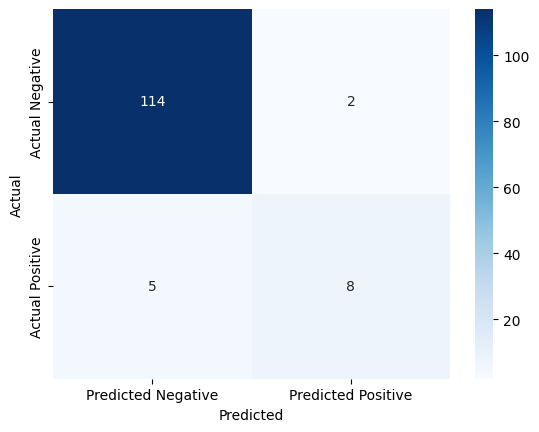


Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.98      0.97       116
           1       0.80      0.62      0.70        13

    accuracy                           0.95       129
   macro avg       0.88      0.80      0.83       129
weighted avg       0.94      0.95      0.94       129



In [81]:
# predict on the validation set
y_val_pred_knn = knn.predict(X_val)
y_val_pred_knn_proba = knn.predict_proba(X_val)[:, 1] # Probability of the positive class

# Evaluate the model
precision = precision_score(y_val, y_val_pred_knn)
recall = recall_score(y_val, y_val_pred_knn)
f1 = f1_score(y_val, y_val_pred_knn)
roc_auc = roc_auc_score(y_val, y_val_pred_knn)

# Display the evaluation metrics
print(f"KNN - Precision: {precision}")
print(f"KNN - Recall: {recall}")
print(f"KNN - F1 Score: {f1}")
print(f"KNN - ROC AUC Score: {roc_auc}")

# Print the confusion matrix and classification report
print("KNN Confusion Matrix:")
conf_matrix = confusion_matrix(y_val, y_val_pred_knn)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted Negative', 'Predicted Positive'], yticklabels=['Actual Negative', 'Actual Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

print("\nClassification Report:")
print(classification_report(y_val, y_val_pred_knn))

Based on the evaluation metrics:

- **Overall Performance:** The K-Nearest Neighbors (KNN) model achieved an overall accuracy of **95%**, demonstrating strong predictive capability on the validation set.
- **Precision:** 80%
- **Recall:** 61.54%
- **F1 Score:** 69.57%
- **ROC AUC Score:** 79.91%

While the model performs well overall, the lower recall suggests that about 38% of actual death cases were not identified. Improving recall is crucial in our case to ensure critical outcomes are not missed.


KNN ROC curve and AUC score:

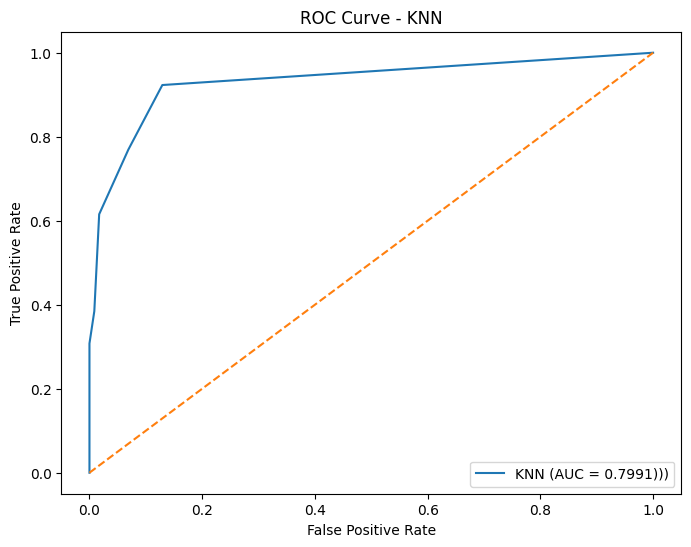

In [82]:
# Compute ROC curve
fpr, tpr, thresholds = roc_curve(y_val, y_val_pred_knn_proba)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'KNN (AUC = {roc_auc:.4f})))')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc = 'lower right')
plt.title('ROC Curve - KNN')
plt.show()

**4.2.2 Logistic Regression** <br />
Training the Logistic Regression model on the dataset.

In [83]:
# Logistic Regression model
log_reg = LogisticRegression(max_iter=120)
log_reg.fit(X_train, y_train)

LogisticRegression(max_iter=120)

Evaluation of the model using the validation set.

Logistic Regression - Precision: 0.9166666666666666
Logistic Regression - Recall: 0.8461538461538461
Logistic Regression - F1 Score: 0.88
Logistic Regression - ROC AUC Score: 0.918766578249337
Logistic Regression Confusion Matrix:


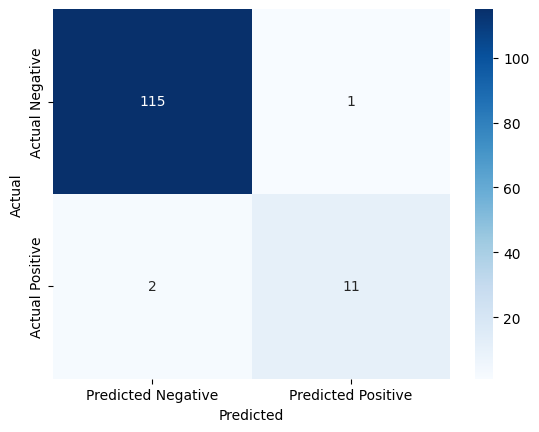


Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.99      0.99       116
           1       0.92      0.85      0.88        13

    accuracy                           0.98       129
   macro avg       0.95      0.92      0.93       129
weighted avg       0.98      0.98      0.98       129



In [84]:
# Predicting the validation set
y_val_pred_log_reg = log_reg.predict(X_val)
y_val_pred_log_reg_proba = log_reg.predict_proba(X_val)[:, 1]  # Probability of the positive class

# Evaluate the model
precision_log_reg = precision_score(y_val, y_val_pred_log_reg)
recall_log_reg = recall_score(y_val, y_val_pred_log_reg)
f1_log_reg = f1_score(y_val, y_val_pred_log_reg)
roc_auc_log_reg = roc_auc_score(y_val, y_val_pred_log_reg)

# Display the evaluation metrics
print(f"Logistic Regression - Precision: {precision_log_reg}")
print(f"Logistic Regression - Recall: {recall_log_reg}")
print(f"Logistic Regression - F1 Score: {f1_log_reg}")
print(f"Logistic Regression - ROC AUC Score: {roc_auc_log_reg}")

# Confusion Matrix and Classification Report
print("Logistic Regression Confusion Matrix:")
conf_matrix_log_reg = confusion_matrix(y_val, y_val_pred_log_reg)
sns.heatmap(conf_matrix_log_reg, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted Negative', 'Predicted Positive'], yticklabels=['Actual Negative', 'Actual Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

print("\nLogistic Regression Classification Report:")
print(classification_report(y_val, y_val_pred_log_reg))

Based on the evaluation metrics:

- **Overall Performance:** The Logistic Regression model achieved a high overall accuracy of **98%**, indicating strong predictive capabilities on the validation set.
- **Precision:** 91.67%
- **Recall:** 84.62%
- **F1 Score:** 88%
- **ROC AUC Score:** 91.88%

While the model performs well overall, the slightly lower recall suggests that about 15% of actual death cases were not identified. Improving recall is crucial in a medical context to ensure critical outcomes are not missed.

Logistic Regression ROC curve and AUC score:

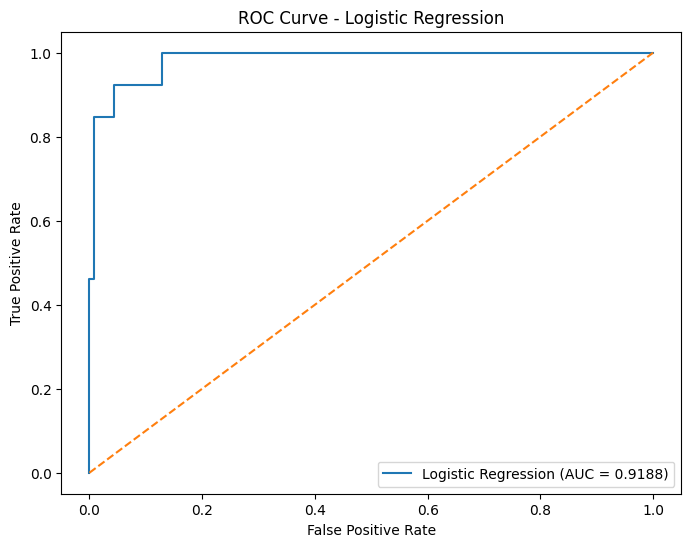

In [85]:
# Compute ROC curve
fpr_log_reg, tpr_log_reg, thresholds_log_reg = roc_curve(y_val, y_val_pred_log_reg_proba)

plt.figure(figsize=(8, 6))
plt.plot(fpr_log_reg, tpr_log_reg, label=f'Logistic Regression (AUC = {roc_auc_log_reg:.4f})')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.title('ROC Curve - Logistic Regression')
plt.show()

**4.2.3 Naive Bayes** <br />
Training the Naive Bayes model on the dataset.

In [86]:
# Naive Bayes model
naive_bayes = GaussianNB()
naive_bayes.fit(X_train, y_train)

GaussianNB()

Evaluation of the model using the validation set.

Naive Bayes - Precision: 0.23076923076923078
Naive Bayes - Recall: 0.9230769230769231
Naive Bayes - F1 Score: 0.36923076923076925
Naive Bayes - ROC AUC Score: 0.7891246684350133
Naive Bayes Confusion Matrix:


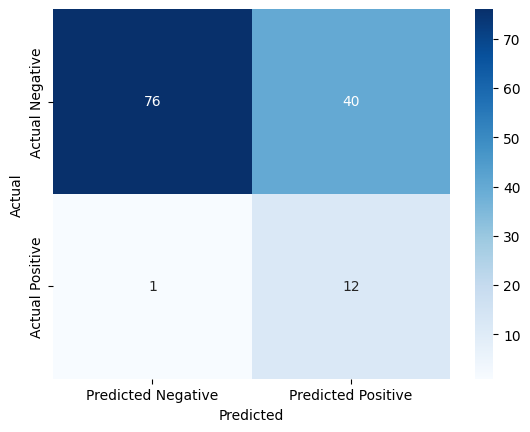


Naive Bayes Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.66      0.79       116
           1       0.23      0.92      0.37        13

    accuracy                           0.68       129
   macro avg       0.61      0.79      0.58       129
weighted avg       0.91      0.68      0.75       129



In [87]:
# Predicting the validation set
y_val_pred_nb = naive_bayes.predict(X_val)
y_val_pred_nb_proba = naive_bayes.predict_proba(X_val)[:, 1]  # Probability of the positive class

# Evaluate the model
precision_nb = precision_score(y_val, y_val_pred_nb)
recall_nb = recall_score(y_val, y_val_pred_nb)
f1_nb = f1_score(y_val, y_val_pred_nb)
roc_auc_nb = roc_auc_score(y_val, y_val_pred_nb)

# Display the evaluation metrics
print(f"Naive Bayes - Precision: {precision_nb}")
print(f"Naive Bayes - Recall: {recall_nb}")
print(f"Naive Bayes - F1 Score: {f1_nb}")
print(f"Naive Bayes - ROC AUC Score: {roc_auc_nb}")

# Confusion Matrix and Classification Report
print("Naive Bayes Confusion Matrix:")
conf_matrix_nb = confusion_matrix(y_val, y_val_pred_nb)
sns.heatmap(conf_matrix_nb, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted Negative', 'Predicted Positive'], yticklabels=['Actual Negative', 'Actual Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

print("\nNaive Bayes Classification Report:")
print(classification_report(y_val, y_val_pred_nb))

Based on the evaluation metrics:

- **Overall Performance:** The Naive Bayes model achieved an overall accuracy of **68%**, which is relatively low compared to other models.
- **Precision:** 23.08%
- **Recall:** 92.31%
- **F1 Score:** 36.92%
- **ROC AUC Score:** 78.91%

While the model exhibits high recall, indicating that most actual death cases were identified, the very low precision suggests a high number of false positives. It's true that we care more about recall in medical settings to avoid missing critical cases, but the high false positive rate is still not the ideal scenario.

Naive Bayes ROC curve and AUC score:

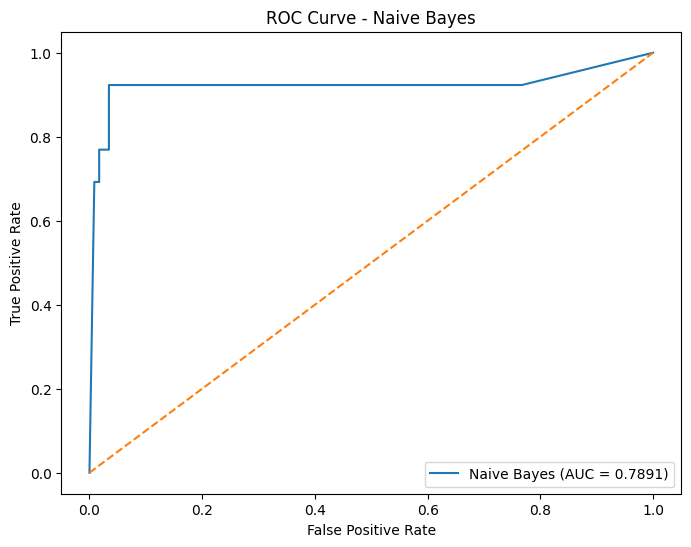

In [88]:
# Plot ROC curve for Naive Bayes
fpr_nb, tpr_nb, thresholds_nb = roc_curve(y_val, y_val_pred_nb_proba)

plt.figure(figsize=(8, 6))
plt.plot(fpr_nb, tpr_nb, label=f'Naive Bayes (AUC = {roc_auc_nb:.4f})')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.title('ROC Curve - Naive Bayes')
plt.show()

**4.2.4 Support Vector Machine** <br />
Training the Support Vector Machine model on the dataset.

In [89]:
# Support Vector Machine (SVC)
svm = SVC(kernel='linear', probability=True, random_state=42)

# Fit the model on the training data
svm.fit(X_train, y_train)

SVC(kernel='linear', probability=True, random_state=42)

Evaluation of the model using the validation set.

SVM - Precision: 0.8461538461538461
SVM - Recall: 0.8461538461538461
SVM - F1 Score: 0.8461538461538461
SVM - ROC AUC Score: 0.9144562334217506
SVM Confusion Matrix:


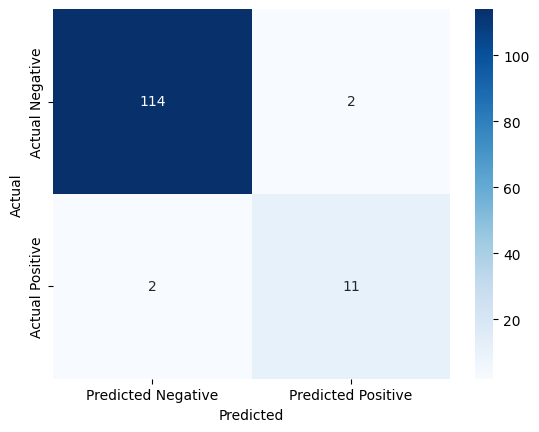


SVM Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.98      0.98       116
           1       0.85      0.85      0.85        13

    accuracy                           0.97       129
   macro avg       0.91      0.91      0.91       129
weighted avg       0.97      0.97      0.97       129



In [90]:
# Predicting the validation set
y_val_pred_svm = svm.predict(X_val)
y_val_pred_svm_proba = svm.predict_proba(X_val)[:, 1]  # Probability of the positive class

# Evaluate the model
precision_svm = precision_score(y_val, y_val_pred_svm)
recall_svm = recall_score(y_val, y_val_pred_svm)
f1_svm = f1_score(y_val, y_val_pred_svm)
roc_auc_svm = roc_auc_score(y_val, y_val_pred_svm)

# Display the evaluation metrics
print(f"SVM - Precision: {precision_svm}")
print(f"SVM - Recall: {recall_svm}")
print(f"SVM - F1 Score: {f1_svm}")
print(f"SVM - ROC AUC Score: {roc_auc_svm}")

# Confusion Matrix and Classification Report
print("SVM Confusion Matrix:")
conf_matrix_svm = confusion_matrix(y_val, y_val_pred_svm)
sns.heatmap(conf_matrix_svm, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted Negative', 'Predicted Positive'], yticklabels=['Actual Negative', 'Actual Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

print("\nSVM Classification Report:")
print(classification_report(y_val, y_val_pred_svm))

Based on the evaluation metrics:

- **Overall Performance:** The Support Vector Machine (SVM) model achieved a high overall accuracy of **97%**, indicating strong predictive capabilities on the validation set.
- **Precision:** 84.62%
- **Recall:** 84.62%
- **F1 Score:** 84.62%
- **ROC AUC Score:** 91.45%

The SVM model performs well overall, with balanced precision and recall. This is important in a medical context to ensure that both false positives and false negatives are minimized. The model's ROC AUC score is also high, indicating good overall performance. <br />
The model's recall is slightly lower than other models but still acceptable.

SVM ROC curve and AUC score:

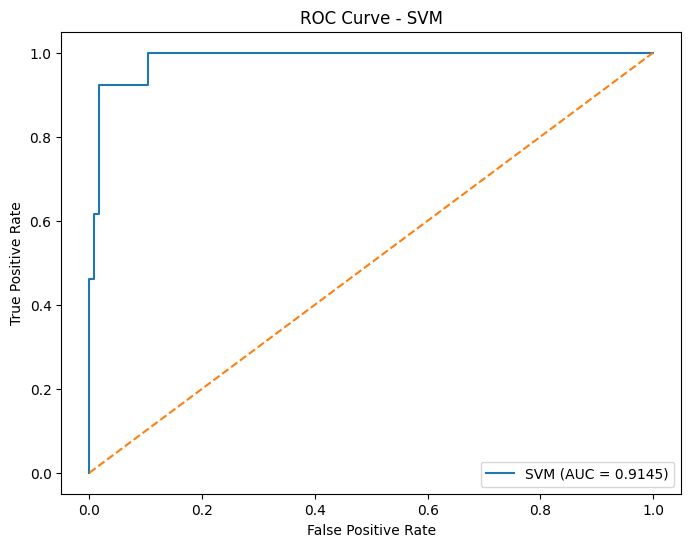

In [91]:
# Plot ROC curve for SVM
fpr_svm, tpr_svm, thresholds_svm = roc_curve(y_val, y_val_pred_svm_proba)

plt.figure(figsize=(8, 6))
plt.plot(fpr_svm, tpr_svm, label=f'SVM (AUC = {roc_auc_svm:.4f})')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.title('ROC Curve - SVM')
plt.show()

**4.2.5 Decision Tree** <br />
Training the Decision Tree model on the dataset.

In [92]:
# Decision Tree model
decision_tree = DecisionTreeClassifier(random_state=42)

# Fit the model on the training data
decision_tree.fit(X_train, y_train)

DecisionTreeClassifier(random_state=42)

Evaluation of the model using the validation set.

Decision Tree - Precision: 0.9230769230769231
Decision Tree - Recall: 0.9230769230769231
Decision Tree - F1 Score: 0.9230769230769231
Decision Tree - ROC AUC Score: 0.9572281167108754
Decision Tree Confusion Matrix:


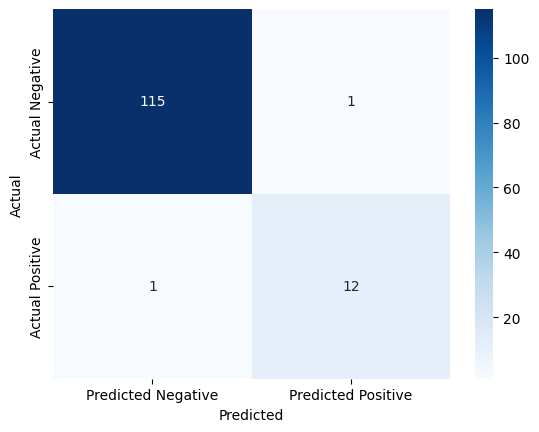


Decision Tree Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       116
           1       0.92      0.92      0.92        13

    accuracy                           0.98       129
   macro avg       0.96      0.96      0.96       129
weighted avg       0.98      0.98      0.98       129



In [93]:
# Predicting the validation set
y_val_pred_dt = decision_tree.predict(X_val)
y_val_pred_dt_proba = decision_tree.predict_proba(X_val)[:, 1]  # Probability of the positive class

# Evaluate the model
precision_dt = precision_score(y_val, y_val_pred_dt)
recall_dt = recall_score(y_val, y_val_pred_dt)
f1_dt = f1_score(y_val, y_val_pred_dt)
roc_auc_dt = roc_auc_score(y_val, y_val_pred_dt)

# Display the evaluation metrics
print(f"Decision Tree - Precision: {precision_dt}")
print(f"Decision Tree - Recall: {recall_dt}")
print(f"Decision Tree - F1 Score: {f1_dt}")
print(f"Decision Tree - ROC AUC Score: {roc_auc_dt}")

# Confusion Matrix and Classification Report
print("Decision Tree Confusion Matrix:")
conf_matrix_dt = confusion_matrix(y_val, y_val_pred_dt)
sns.heatmap(conf_matrix_dt, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted Negative', 'Predicted Positive'], yticklabels=['Actual Negative', 'Actual Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

print("\nDecision Tree Classification Report:")
print(classification_report(y_val, y_val_pred_dt))

Based on the evaluation metrics:

- **Overall Performance:** The Decision Tree model achieved a high overall accuracy of **98%**, indicating strong predictive capabilities on the validation set.
- **Precision:** 92.31%
- **Recall:** 92.31%
- **F1 Score:** 92.31%
- **ROC AUC Score:** 95.72%

The model performs well overall, with balanced precision and recall. This balance is crucial in a medical context to ensure that both false positives and false negatives are minimized. The model's high ROC AUC score indicates excellent overall performance.


Decision Tree ROC curve and AUC score:

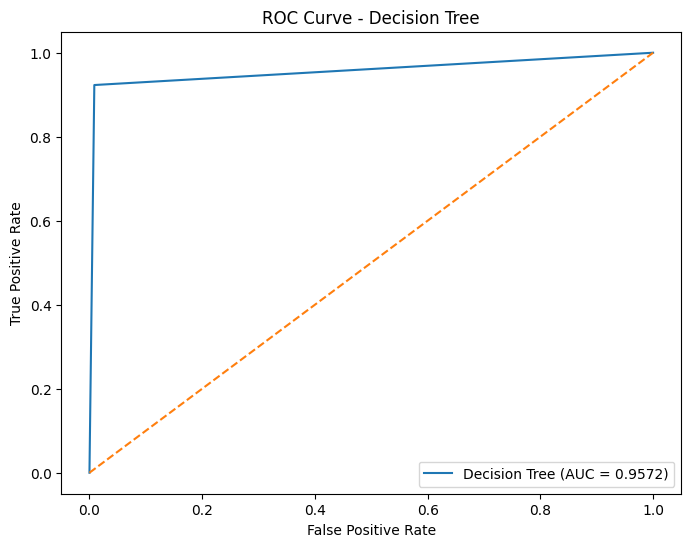

In [94]:
# Plot ROC curve for Decision Tree
fpr_dt, tpr_dt, thresholds_dt = roc_curve(y_val, y_val_pred_dt_proba)

plt.figure(figsize=(8, 6))
plt.plot(fpr_dt, tpr_dt, label=f'Decision Tree (AUC = {roc_auc_dt:.4f})')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.title('ROC Curve - Decision Tree')
plt.show()

### 5. Model Evaluation and Comparison